In [14]:
import pandas as pd
from datetime import timedelta
import re
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer


## Building the Dataset

In [15]:
tweets_df = pd.read_csv("data/stock_tweets.csv", parse_dates=["Date"])
stocks_df = pd.read_csv("data/stock_yfinance_data.csv", parse_dates=["Date"])

In [16]:
# Ensure consistent date formatting (floor tweets to day)
tweets_df["Date"] = pd.to_datetime(tweets_df["Date"]).dt.date
stocks_df["Date"] = pd.to_datetime(stocks_df["Date"]).dt.date

# Create a lookup dictionary for stocks by name
stocks_grouped = stocks_df.groupby("Stock Name")

In [18]:
# Helper function to get historical and future stock windows
def get_stock_windows(stock_name, date):
    df = stocks_grouped.get_group(stock_name)
    df = df.sort_values("Date")
    # past 7 days (exclusive of current day)
    hist_window = df[(df["Date"] < date) & (df["Date"] >= date - timedelta(days=9))]
    # future 7 days (inclusive)
    future_window = df[(df["Date"] > date) & (df["Date"] <= date + timedelta(days=9))]
    return hist_window, future_window

In [19]:
# Process tweets
examples = []

for _, row in tweets_df.iterrows():
    stock = row["Stock Name"]
    date = row["Date"]
    tweet = row["Tweet"]

    if stock not in stocks_grouped.groups:
        continue

    hist, future = get_stock_windows(stock, date)
    if len(hist) < 5 or len(future) < 5:
        continue  # skip if incomplete window

    examples.append({
        "tweet": tweet,
        "stock": stock,
        "date": date,
        "history": hist,
        "future": future
    })

In [20]:
# Nested dict: stock_name → date → {tweets, history, future}
examples_by_stock = defaultdict(lambda: defaultdict(lambda: {"tweets": [], "history": None, "future": None}))

for ex in examples:
    stock = ex["stock"]
    date = ex["date"]

    # Append the tweet
    examples_by_stock[stock][date]["tweets"].append(ex["tweet"])

    # Attach history and future only if not already present
    if examples_by_stock[stock][date]["history"] is None:
        examples_by_stock[stock][date]["history"] = ex["history"]
        examples_by_stock[stock][date]["future"] = ex["future"]

In [21]:
records = []

for stock, dated_dict in examples_by_stock.items():
    for date, content in dated_dict.items():
        records.append({
            "Stock": stock,
            "Date": date,
            "Tweets": pd.DataFrame({"Tweets": content["tweets"]}),
            "History": content["history"],  # This can stay as a DataFrame per row
            "Future": content["future"]
        })

df = pd.DataFrame(records)

In [22]:
print(df['Date'].value_counts())
print(df['Stock'].value_counts())

Date
2022-04-23    22
2022-01-02    21
2022-01-05    21
2022-02-02    21
2022-04-24    21
              ..
2022-06-14    11
2021-12-24    11
2022-08-06    11
2021-12-25    10
2022-09-03     8
Name: count, Length: 333, dtype: int64
Stock
TSLA    333
MSFT    333
PG      333
AMZN    333
AAPL    333
TSM     333
NIO     330
AMD     325
GOOG    301
NFLX    290
META    283
PYPL    243
DIS     229
COST    200
BA      199
KO      179
INTC    159
CRM     143
ZS      124
ENPH    117
XPEV    114
VZ       89
BX       37
F        26
NOC      26
Name: count, dtype: int64


In [23]:
tweets_df = df 
print(tweets_df.head())

  Stock        Date                                             Tweets  \
0  TSLA  2022-09-22                                                ...   
1  TSLA  2022-09-21                                                ...   
2  TSLA  2022-09-20                                                ...   
3  TSLA  2022-09-19                                                ...   
4  TSLA  2022-09-18                                                ...   

                                             History  \
0             Date        Open        High       ...   
1             Date        Open        High       ...   
2             Date        Open        High       ...   
3             Date        Open        High       ...   
4             Date        Open        High       ...   

                                              Future  
0             Date        Open        High       ...  
1             Date        Open        High       ...  
2             Date        Open        High       ... 

In [16]:
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+", "", tweet)  # remove URLs
    tweet = re.sub(r"\s+", " ", tweet).strip()  # normalize spaces
    return tweet

## T5 Sentence Transformers Encoding

In [25]:
t5_encoder = SentenceTransformer("sentence-transformers/sentence-t5-base")

In [43]:
print(tweets_df["Tweets"][0].iloc[0])

                                               Tweets
0   $TSLA shares have increased in value by 12 bas...
1   Every day that you hold $TSLA, the intrinsic v...
2   Tesla bears ambushed the bulls today with a re...
3   Year-to-Date performance:\n\n1. $FB: -58%\n2. ...
4   69 likes for some charts!\n❤️ \n\n$SPY $QQQ $TSLA
..                                                ...
78  I will buy ☕️ for whoever correctly guesses th...
79  $TSLA\nI still think its possible my thesis po...
80  ⚡️Watchlist for 9/22/22⚡️\n\n✅ $SPY \n📈Calls O...
81  Trade plan for Thursday ✅\n\n$SPX negative rea...
82  @Teslaconomics Hold tight $TSLA investors. Our...

[83 rows x 1 columns]


In [41]:
embedding = t5_encoder.encode(tweets_df["Tweets"][0].iloc[0])

(1, 768)


In [45]:
from torch.utils.data import Dataset
import torch


class TweetEmbeddingDataset(Dataset):
    def __init__(self, tweet_embeddings: list[dict]):
        self.samples = tweet_embeddings

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return {
            "stock": sample["stock"],
            "center_date": sample["center_date"],
            "avg_embedding": sample["avg_embedding"]
        }

In [46]:

def preprocess_tweet_df(tweets_df, t5_encoder) -> list[dict]:
    """
    tweets_df: DataFrame with ['Stock', 'Date', 'Tweets']
        where 'Tweets' is a DataFrame with a single 'Tweets' column
    t5_encoder: SentenceTransformer instance
    returns: list of {"stock", "center_date", "avg_embedding"}
    """
    results = []

    for idx, row in tweets_df.iterrows():
        stock = row["Stock"]
        date = pd.to_datetime(row["Date"])
        tweets_df_inner = row["Tweets"]

        # Extract tweets from nested df
        tweet_list = tweets_df_inner["Tweets"].tolist()

        if len(tweet_list) == 0:
            continue  # skip empty entries

        # Encode each tweet individually
        embs = t5_encoder.encode(tweet_list, convert_to_tensor=True)  # (N, 768)

        # Average embeddings
        avg_embedding = embs.mean(dim=0)  # (768,)
        results.append({
            "stock": stock,
            "center_date": date,
            "avg_embedding": avg_embedding
        })

    return results

In [47]:
tweet_dataset = TweetEmbeddingDataset(preprocess_tweet_df(tweets_df, t5_encoder))

In [68]:
import torch.nn as nn

class T5ProjectionHead(nn.Module):
    def __init__(self, input_dim=768, proj_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, proj_dim),
            nn.LayerNorm(proj_dim)
        )

    def forward(self, x):
        """
        x: (B, 768)
        returns: (B, 256)
        """
        return self.net(x)

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

# 1. Load the frozen T5 encoder
t5_encoder = SentenceTransformer("sentence-transformers/sentence-t5-base")

# 2. Get averaged tweet embedding
def encode_tweets(tweets: list[str]) -> torch.Tensor:
    embs = t5_encoder.encode(tweets, convert_to_tensor=True)  # (N, 768)
    return embs.mean(dim=0)  # (768,)

# 3. Projection
t5_proj_head = T5ProjectionHead(input_dim=768, proj_dim=256)

# 4. Forward pass
tweets = ["stock is crashing", "bad earnings report"]  # example
tweet_embedding = encode_tweets(tweets)
projected = t5_proj_head(tweet_embedding)  # (256,)

## PatchTST

In [72]:
import numpy as np
import torch
from torch.utils.data import Dataset
import pandas as pd

class StockWindowDataset(Dataset):
    def __init__(self, df, context_len=7, pred_len=7, feature_cols=["Close"], eps=1e-6):
        self.context_len = context_len
        self.pred_len = pred_len
        self.feature_cols = feature_cols
        self.eps = eps

        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values(by=["Stock Name", "Date"])

        self.samples = []
        for stock, group in df.groupby("Stock Name"):
            group = group.reset_index(drop=True)
            for i in range(context_len, len(group) - pred_len):
                x_window = group.loc[i - context_len:i - 1, feature_cols].values
                y_window = group.loc[i:i + pred_len - 1, feature_cols].values

                if len(x_window) == context_len and len(y_window) == pred_len:
                    full_window = np.concatenate((x_window, y_window), axis=0).astype(np.float32)  # (14, F)

                    # === Normalize the full window ===
                    mean = full_window.mean(axis=0, keepdims=True)
                    std = full_window.std(axis=0, keepdims=True)
                    full_window_norm = (full_window - mean) / (std + self.eps)

                    self.samples.append({
                        "x_context": x_window.astype(np.float32),
                        "y_future": y_window.astype(np.float32),
                        "full_window": full_window_norm,
                        "stock": stock,
                        "center_date": group.loc[i, "Date"]
                    })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return {
            "x_context": torch.tensor(sample["x_context"]),
            "y_future": torch.tensor(sample["y_future"]),
            "full_window": torch.tensor(sample["full_window"]),
            "stock": sample["stock"],
            "center_date": sample["center_date"]
        }

In [96]:
# Instantiate dataset on the simulated dataframe
df = pd.read_csv("data/stock_yfinance_data.csv", parse_dates=["Date"])
ts_dataset = StockWindowDataset(df, context_len=7, pred_len=7, feature_cols=["Close"])

# Preview one sample
sample = ts_dataset[0]
sample

{'x_context': tensor([[141.5000],
         [142.6500],
         [139.1400],
         [141.1100],
         [142.0000],
         [143.2900],
         [142.9000]]),
 'y_future': tensor([[142.8100],
         [141.5100],
         [140.9100],
         [143.7600],
         [144.8400],
         [146.5500],
         [148.7600]]),
 'full_window': tensor([[-0.6261],
         [-0.1398],
         [-1.6240],
         [-0.7910],
         [-0.4147],
         [ 0.1308],
         [-0.0341],
         [-0.0722],
         [-0.6219],
         [-0.8756],
         [ 0.3295],
         [ 0.7862],
         [ 1.5093],
         [ 2.4437]]),
 'stock': 'AAPL',
 'center_date': Timestamp('2021-10-11 00:00:00')}

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchTSTEncoder(nn.Module):
    def __init__(self, input_dim=1, patch_len=4, stride=1, model_dim=128, depth=2,
                 num_heads=4, proj_dim=256):
        super().__init__()
        self.patch_len = patch_len
        self.stride = stride

        # === Patch Embedding ===
        # We'll use a 1D convolution to create non-overlapping (or strided) patches
        self.patch_embed = nn.Conv1d(
            in_channels=input_dim,
            out_channels=model_dim,
            kernel_size=patch_len,
            stride=stride
        )

        # === Positional Encoding (learned) ===
        self.pos_encoding = nn.Parameter(torch.randn(1, 100, model_dim))  # max 100 patches

        # === Transformer Encoder ===
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # === Projection Head for CLIP-style contrastive loss ===
        self.projection_head = nn.Sequential(
            nn.Linear(model_dim, proj_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(proj_dim, proj_dim),
            nn.LayerNorm(proj_dim)
        )

    def forward(self, x):
        """
        x: Tensor of shape (B, T, F) where:
           B = batch size
           T = time steps (e.g., 14)
           F = input features (e.g., 1 for 'Close')

        Returns:
            z: contrastive embedding of shape (B, proj_dim)
        """

        B, T, F = x.shape  # example: (32, 14, 1)

        # Transpose to shape (B, F, T) for Conv1D
        x = x.permute(0, 2, 1)  # (B, F, T)

        # Apply patch embedding: results in shape (B, model_dim, Num_Patches)
        x = self.patch_embed(x)  # -> (B, model_dim, P)
        x = x.permute(0, 2, 1)   # -> (B, P, model_dim)

        # Add positional encodings (crop or pad as needed)
        P = x.size(1)
        pos = self.pos_encoding[:, :P, :]  # (1, P, model_dim)
        x = x + pos

        # Apply transformer encoder
        x_encoded = self.encoder(x)  # (B, P, model_dim)

        # Pooling: mean-pooling over patch dimension
        pooled = x_encoded.mean(dim=1)  # (B, model_dim)

        # Project to contrastive space
        z = self.projection_head(pooled)  # (B, proj_dim)
        return z

In [11]:
model = PatchTSTEncoder(input_dim=1)
z = model(sample["full_window"].unsqueeze(0))

## Contrastive Loss

In [52]:
from datetime import datetime

def split_dataset_by_date(dataset, date_field="center_date", split_ratio=0.8):
    # Extract and sort all dates
    all_dates = sorted(set(pd.to_datetime([s[date_field] for s in dataset.samples])))
    split_idx = int(len(all_dates) * split_ratio)
    cutoff_date = all_dates[split_idx]

    train_samples = [s for s in dataset.samples if pd.to_datetime(s[date_field]) < cutoff_date]
    val_samples = [s for s in dataset.samples if pd.to_datetime(s[date_field]) >= cutoff_date]

    return train_samples, val_samples

In [48]:
class ContrastiveDualDataset(Dataset):
    def __init__(self, ts_dataset, tweet_dataset):
        # Build a lookup from (stock, date) → tweet_embedding
        self.tweet_map = {
            (sample["stock"], pd.to_datetime(sample["center_date"])): sample["avg_embedding"]
            for sample in tweet_dataset.samples
        }

        # Filter the ts_dataset to only keep matched pairs
        self.paired_samples = []
        for sample in ts_dataset.samples:
            key = (sample["stock"], pd.to_datetime(sample["center_date"]))
            if key in self.tweet_map:
                self.paired_samples.append({
                    "ts_window": sample["full_window"],
                    "tweet_embedding": self.tweet_map[key]
                })

    def __len__(self):
        return len(self.paired_samples)

    def __getitem__(self, idx):
        sample = self.paired_samples[idx]
        return {
            "ts_window": torch.tensor(sample["ts_window"]),           # (14, 1)
            "tweet_embedding": sample["tweet_embedding"]              # (768,)
        }


In [49]:
def contrastive_loss(text_proj, ts_proj, temperature=0.07):
    """
    text_proj: (B, D)
    ts_proj: (B, D)
    returns scalar contrastive loss
    """
    B, D = text_proj.size()

    # Normalize embeddings for cosine similarity
    text_proj = F.normalize(text_proj, dim=-1)
    ts_proj = F.normalize(ts_proj, dim=-1)

    # Similarity matrix (B x B)
    logits = torch.matmul(text_proj, ts_proj.T) / temperature

    labels = torch.arange(B, device=text_proj.device)
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.T, labels)

    return (loss_i2t + loss_t2i) / 2

In [101]:
import torch
import torch.nn.functional as F

def evaluate_retrieval(model_ts, model_tweet, val_loader, device="cuda", ks=(1, 5, 10)):
    """
    Evaluate retrieval performance: how often the correct time series is retrieved
    for a given tweet in the top-k most similar embeddings.

    Args:
        model_ts: PatchTST encoder
        model_tweet: T5 projection head
        val_loader: DataLoader yielding batches with 'ts_window' and 'tweet_embedding'
        device: "cuda" or "cpu"
        ks: list of k-values for Recall@k

    Returns:
        dict with recall@k and mrr
    """
    model_ts.eval()
    model_tweet.eval()

    all_ts_embs = []
    all_text_embs = []

    with torch.no_grad():
        for batch in val_loader:
            ts = batch["ts_window"].to(device)
            tweet = batch["tweet_embedding"].to(device)

            ts_proj = model_ts(ts)  # (B, D)
            text_proj = model_tweet(tweet)  # (B, D)

            all_ts_embs.append(ts_proj)
            all_text_embs.append(text_proj)

    # Stack all embeddings across batches
    all_ts_embs = F.normalize(torch.cat(all_ts_embs, dim=0), dim=-1)      # (N, D)
    all_text_embs = F.normalize(torch.cat(all_text_embs, dim=0), dim=-1)  # (N, D)

    # Compute cosine similarity matrix
    sim_matrix = torch.matmul(all_text_embs, all_ts_embs.T)  # (N, N)

    # Ground-truth matches are on the diagonal
    N = sim_matrix.size(0)
    labels = torch.arange(N, device=device)

    # Compute ranks for each row
    _, indices = sim_matrix.topk(k=max(ks), dim=-1, largest=True)  # (N, max_k)

    # Calculate Recall@k
    recall_at_k = {k: 0 for k in ks}
    mrr_total = 0

    for i in range(N):
        rank_list = indices[i].tolist()
        true_index = labels[i].item()

        # MRR: 1 / (rank + 1)
        if true_index in rank_list:
            rank = rank_list.index(true_index)
            mrr_total += 1.0 / (rank + 1)
        else:
            mrr_total += 0

        for k in ks:
            if true_index in rank_list[:k]:
                recall_at_k[k] += 1

    # Normalize results
    for k in ks:
        recall_at_k[k] /= N
    mrr = mrr_total / N

    return {
        **{f"recall@{k}": recall_at_k[k] for k in ks},
        "mrr": mrr
    }

In [109]:
import matplotlib.pyplot as plt

def train_contrastive(
    model_ts, model_tweet, train_loader, val_loader,
    device="cuda", epochs=10, lr=1e-4, wd=1e-5
):
    model_ts.to(device)
    model_tweet.to(device)

    optimizer = torch.optim.Adam(
        list(model_ts.parameters()) + list(model_tweet.parameters()),
        lr=lr, weight_decay=wd  # add weight decay here
    )

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model_ts.train()
        model_tweet.train()
        total_train_loss = 0

        for batch in train_loader:
            ts = batch["ts_window"].to(device)
            tweets = batch["tweet_embedding"].to(device)

            ts_proj = model_ts(ts)
            text_proj = model_tweet(tweets)

            loss = contrastive_loss(text_proj, ts_proj)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        model_ts.eval()
        model_tweet.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                ts = batch["ts_window"].to(device)
                tweets = batch["tweet_embedding"].to(device)

                ts_proj = model_ts(ts)
                text_proj = model_tweet(tweets)

                val_loss = contrastive_loss(text_proj, ts_proj)
                total_val_loss += val_loss.item()

        avg_train = total_train_loss / len(train_loader)
        avg_val = total_val_loss / len(val_loader)

        train_losses.append(avg_train)
        val_losses.append(avg_val)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

        if (epoch + 1) % 5 == 0:
            eval_metrics = evaluate_retrieval(model_ts, model_tweet, val_loader)
            print(f"Retrieval @ epoch {epoch+1}: {eval_metrics}")
            eval_metrics = evaluate_retrieval(model_ts, model_tweet, train_loader)
            print(f"Retrieval @ epoch {epoch+1}: {eval_metrics}")


    # === Plot the losses ===
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Val Loss", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Contrastive Training Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [56]:
class StockWindowDatasetFromSamples(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return {
            "x_context": torch.tensor(sample["x_context"]),
            "y_future": torch.tensor(sample["y_future"]),
            "full_window": torch.tensor(sample["full_window"]),
            "stock": sample["stock"],
            "center_date": sample["center_date"]
        }

In [79]:
import random

def split_by_stock_name(ts_dataset, tweet_dataset, train_ratio=0.8, seed=42):
    # Step 1: Collect all unique stock names
    all_stocks = sorted({s["stock"] for s in ts_dataset.samples})
    random.seed(seed)
    random.shuffle(all_stocks)

    split_idx = int(len(all_stocks) * train_ratio)
    train_stocks = set(all_stocks[:split_idx])
    val_stocks = set(all_stocks[split_idx:])

    # Step 2: Filter each dataset by stock membership
    def filter_dataset(samples, stocks):
        return [s for s in samples if s["stock"] in stocks]

    ts_train = filter_dataset(ts_dataset.samples, train_stocks)
    ts_val = filter_dataset(ts_dataset.samples, val_stocks)

    tweet_train = filter_dataset(tweet_dataset.samples, train_stocks)
    tweet_val = filter_dataset(tweet_dataset.samples, val_stocks)

    return ts_train, ts_val, tweet_train, tweet_val

In [81]:
def print_split_summary(ts_train, ts_val, tweet_train, tweet_val):
    train_stocks = sorted({s["stock"] for s in ts_train})
    val_stocks = sorted({s["stock"] for s in ts_val})

    print("Stock-Based Dataset Split Summary")
    print("=" * 40)
    print(f"Train Stocks ({len(train_stocks)}): {train_stocks}")
    print(f"Val Stocks ({len(val_stocks)}): {val_stocks}")
    print("-" * 40)
    print(f"Train TS Samples:    {len(ts_train):>5}")
    print(f"Train Tweet Samples: {len(tweet_train):>5}")
    print(f"Val TS Samples:      {len(ts_val):>5}")
    print(f"Val Tweet Samples:   {len(tweet_val):>5}")
    print("=" * 40)

In [97]:
from torch.utils.data import DataLoader

# After building your original datasets:
# ts_train, ts_val = split_dataset_by_date(ts_dataset)
# tweet_train, tweet_val = split_dataset_by_date(tweet_dataset)

ts_train, ts_val, tweet_train, tweet_val = split_by_stock_name(ts_dataset, tweet_dataset)
print_split_summary(ts_train, ts_val, tweet_train, tweet_val)

# Re-wrap them
ts_dataset_train = StockWindowDatasetFromSamples(ts_train)
ts_dataset_val = StockWindowDatasetFromSamples(ts_val)
tweet_dataset_train = TweetEmbeddingDataset(tweet_train)
tweet_dataset_val = TweetEmbeddingDataset(tweet_val)

# Build contrastive datasets
train_dual_dataset = ContrastiveDualDataset(ts_dataset_train, tweet_dataset_train)
print(f"Train Dual Dataset Size: {len(train_dual_dataset)}")
val_dual_dataset = ContrastiveDualDataset(ts_dataset_val, tweet_dataset_val)
print(f"Val Dual Dataset Size: {len(val_dual_dataset)}")

# Dataloaders
train_loader = DataLoader(train_dual_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dual_dataset, batch_size=32)



Stock-Based Dataset Split Summary
Train Stocks (20): ['AMD', 'AMZN', 'BX', 'COST', 'CRM', 'F', 'GOOG', 'INTC', 'KO', 'META', 'MSFT', 'NFLX', 'NIO', 'NOC', 'PG', 'PYPL', 'TSM', 'VZ', 'XPEV', 'ZS']
Val Stocks (5): ['AAPL', 'BA', 'DIS', 'ENPH', 'TSLA']
----------------------------------------
Train TS Samples:     4760
Train Tweet Samples:  4201
Val TS Samples:       1190
Val Tweet Samples:    1211
Train Dual Dataset Size: 2849
Val Dual Dataset Size: 823


Epoch 1 | Train Loss: 3.4422 | Val Loss: 3.4530
Epoch 2 | Train Loss: 3.4297 | Val Loss: 3.4529
Epoch 3 | Train Loss: 3.4283 | Val Loss: 3.4527
Epoch 4 | Train Loss: 3.4291 | Val Loss: 3.4526
Epoch 5 | Train Loss: 3.4292 | Val Loss: 3.4524
Retrieval @ epoch 5: {'recall@1': 0.004860267314702308, 'recall@5': 0.007290400972053463, 'recall@10': 0.018226002430133656, 'mrr': 0.006883450018322436}
Retrieval @ epoch 5: {'recall@1': 0.000702000702000702, 'recall@5': 0.002457002457002457, 'recall@10': 0.004212004212004212, 'mrr': 0.0013654192225620798}
Epoch 6 | Train Loss: 3.4268 | Val Loss: 3.4506
Epoch 7 | Train Loss: 3.4224 | Val Loss: 3.4457
Epoch 8 | Train Loss: 3.4177 | Val Loss: 3.4478
Epoch 9 | Train Loss: 3.4026 | Val Loss: 3.4509
Epoch 10 | Train Loss: 3.3950 | Val Loss: 3.4542
Retrieval @ epoch 10: {'recall@1': 0.001215066828675577, 'recall@5': 0.010935601458080195, 'recall@10': 0.014580801944106925, 'mrr': 0.0048212115952091655}
Retrieval @ epoch 10: {'recall@1': 0.0, 'recall@5': 0.

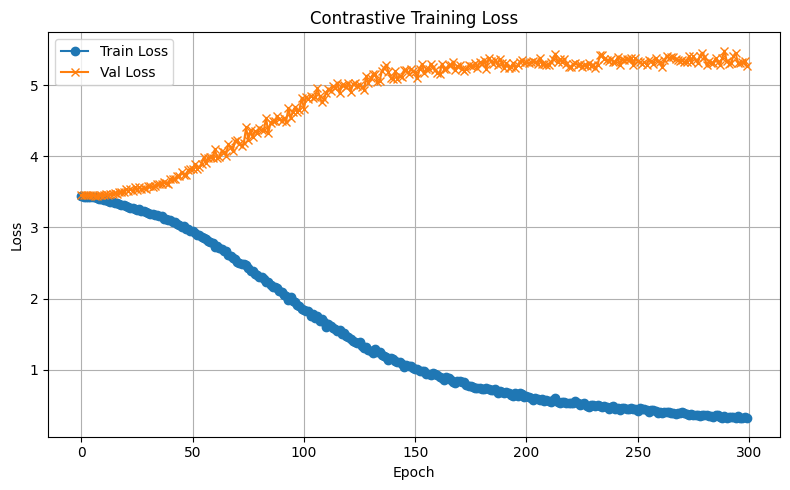

In [110]:
# Train
model_ts = PatchTSTEncoder(input_dim=1, proj_dim=128)
model_tweet = T5ProjectionHead(input_dim=768, proj_dim=128)
train_contrastive(model_ts, model_tweet, train_loader, val_loader, epochs=300, lr=1e-4, wd=1e-5)

In [108]:
metrics = evaluate_retrieval(model_ts, model_tweet, val_loader, device="cuda")
print(metrics)

{'recall@1': 0.002430133657351154, 'recall@5': 0.009720534629404616, 'recall@10': 0.02916160388821385, 'mrr': 0.007675654303843853}
